In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt # 학습과정 시각화
# scale조정, train_test_split 등을 추가

In [3]:
# mnist 데이터 일부(30개)를 이미지 출력하기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape, y_test.shape

11490434/11490434 [==============================] - 2s 0us/step


((10000, 28, 28), (10000,))

In [4]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

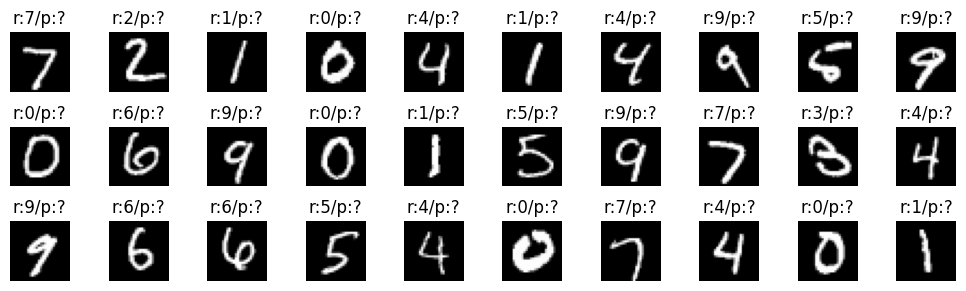

In [5]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col, plt_row))
plt.rcParams['figure.figsize'] = (plt_col, plt_row) # rcParams : run commands Parameters
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
# axarr[1,1].imshow(X_test[11], cmap='gray')
# axarr[1,1].axis('off')
# axarr[1,1].set_title(f'real:{y_test[11]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

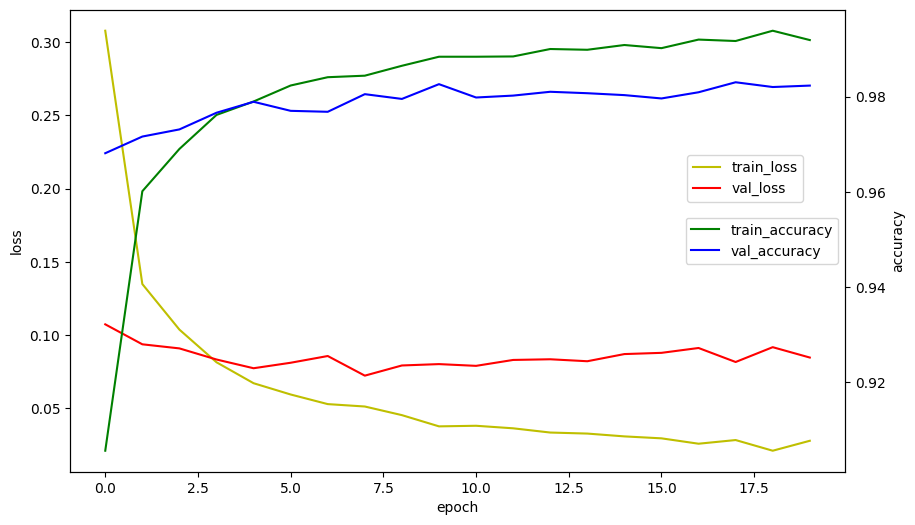

CPU times: total: 16min 58s
Wall time: 3min 19s


In [6]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=20,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)
# 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [7]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9818999767303467

In [8]:
# 틀린갯수
len(test_Y) - len(test_Y) * acc

181.0002326965332

In [9]:
# 틀린 이미지만 출력하기 위해, 실제값과 예측값
# 실제값들
real = test_Y.argmax(axis=1)
real = np.argmax(test_Y, axis=1)
y_test 

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [11]:
# 예측값
y_hat = model.predict(test_X, verbose=0).argmax(axis=1)

In [12]:
y_test.shape, y_hat.shape # 실제값과 예측값

((10000,), (10000,))

In [13]:
# 성능 평가표 (교차표, 혼동행렬)
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,0,0,0,0,0,1,1,3,1
1,0,1121,0,1,0,1,5,1,6,0
2,6,0,1015,0,2,0,1,4,4,0
3,1,0,4,988,0,6,0,5,3,3
4,0,0,3,0,963,0,4,1,2,9
5,2,0,0,5,1,879,1,0,3,1
6,4,2,0,1,2,8,941,0,0,0
7,3,4,10,2,0,0,0,1005,3,1
8,2,1,1,3,2,4,0,2,956,3


In [20]:
plt_row = 2
plt_col = 10
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1~20
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:6/p:5	r:4/p:2	r:9/p:8	r:2/p:7	r:5/p:3	r:9/p:4	r:3/p:7	r:6/p:0	r:4/p:9	r:9/p:8	r:3/p:5	r:8/p:0	r:8/p:2	r:1/p:8	r:2/p:6	r:7/p:3	r:8/p:4	r:5/p:8	r:4/p:9	r:4/p:8	

In [21]:
cnt

20

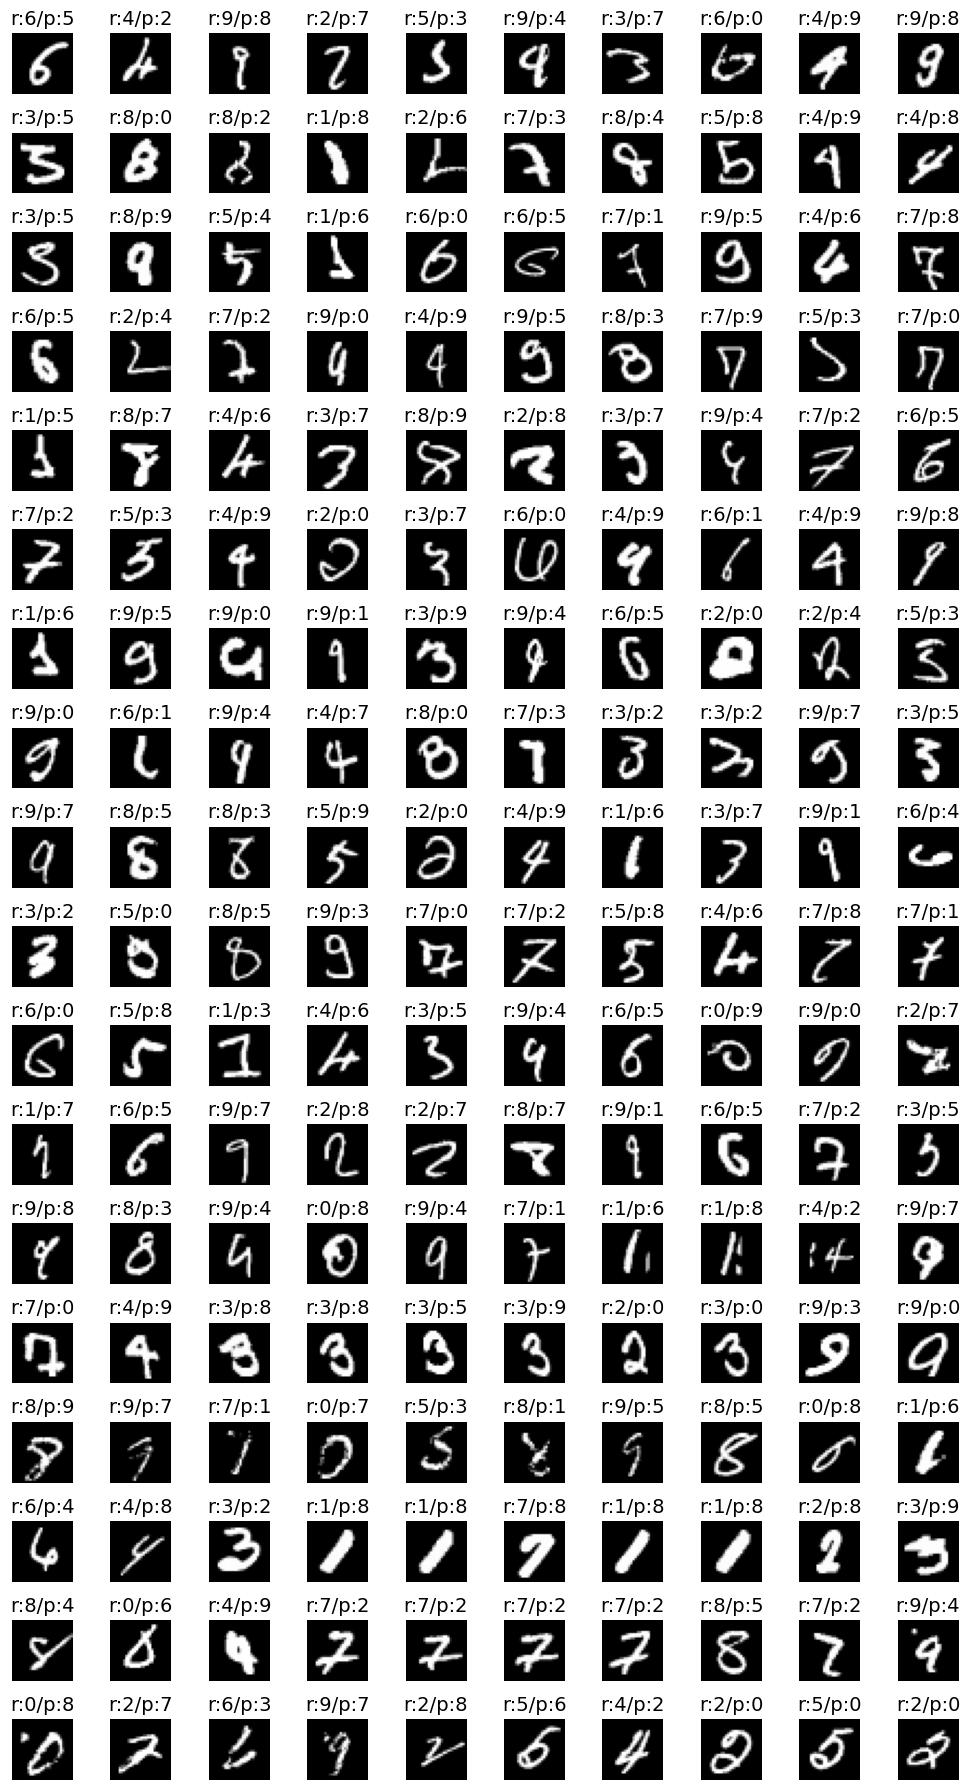

In [22]:
plt_row = 18
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1~180
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
plt.tight_layout()

In [23]:
cnt

180

# 2. CNN
- 컨볼루션 layer -> pooling -> 컨볼루션 layer -> pooling -> Flatten -> DNN

In [24]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
width=28; height=28
model = Sequential([
        Conv2D(filters=32,    # 필터수
               kernel_size=3, # 필터 사이즈 3x3
               padding='same', # zero-padding / padding='valid'기본값
               input_shape = (width, height, 1), # # Conv2D는 3차원 입력받음 : w, h, 1:흑백/3:컬러
               activation='relu'
        ), # 28*28 1채녈이미지를 32개 필터로 특성맵 추출=> 28*28*32특성맵
        MaxPool2D(pool_size=(2,2)), # 가로2배, 세로2배 전체 4배 줄어듦
        Dropout(0.1),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Dropout(0.25),
        Flatten(), # 2304
        Dense(units=128, activation='relu'),
        Dropout(0.4),
        Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)         

In [26]:
%%time
# 1. 데이터 생성 & 전처리
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
train_X = X_train.astype('float32')/255.0
val_X   = X_val.astype('float32')/255.0
test_X  = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape
# 2. 모델 생성
width=28; height=28
model = Sequential()
model.add(Conv2D(32, 3, padding='same', 
                 input_shape=(width, height, 1), activation='relu' # Conv2D는 3차원 입력받음 : w, h, 1:흑백/3:컬러
        ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation='softmax'))
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 학습하기
early_stopping = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(
    filepath='mnist-{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode = 'max',
    verbose=1
)
hist = model.fit(train_X, train_Y, epochs=50, batch_size=32,
                validation_data=(val_X, val_Y),
                callbacks=[early_stopping, checkpoint])

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9249
Epoch 1: val_accuracy improved from -inf to 0.98390, saving model to mnist-01-loss0.0577-val0.9839.h5
1563/1563 [==============================] - 56s 36ms/step - loss: 0.2371 - accuracy: 0.9249 - val_loss: 0.0577 - val_accuracy: 0.9839
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.9717
Epoch 2: val_accuracy improved from 0.98390 to 0.98730, saving model to mnist-02-loss0.0412-val0.9873.h5
1563/1563 [==============================] - 53s 34ms/step - loss: 0.0936 - accuracy: 0.9716 - val_loss: 0.0412 - val_accuracy: 0.9873
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0692 - accuracy: 0.9795
Epoch 3: val_accuracy improved from 0.98730 to 0.98970, saving model to mnist-03-loss0.0345-val0.9897.h5
1563/1563 [==============================] - 52s 33ms/step - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.0345 - val_accura

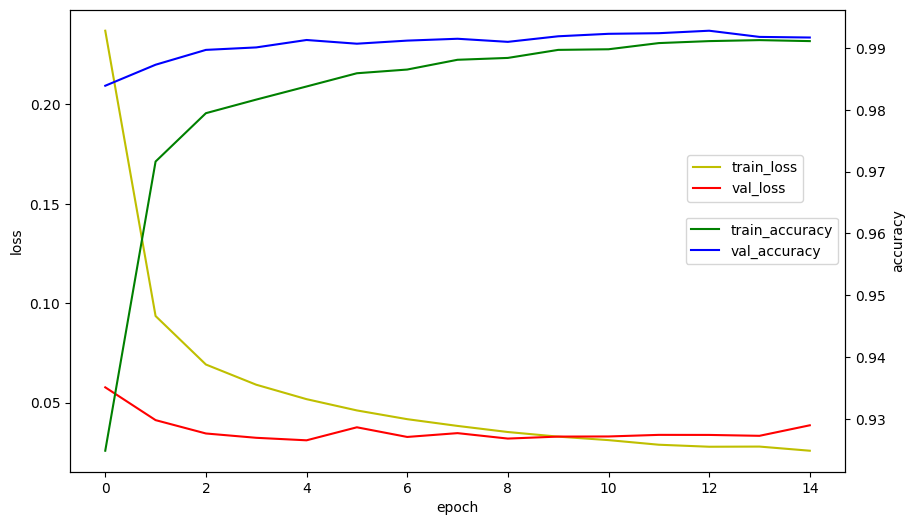

In [27]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [28]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
print('최종 모델 :',acc, loss)

최종 모델 : 0.9923999905586243 0.026438409462571144


In [31]:
model1 = load_model('mnist-12-loss0.0338-val0.9924.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y, verbose=0)
print('model1 :', acc1, loss1)

model1 : 0.9923999905586243 0.02557334676384926


In [32]:
model2 = load_model('mnist-13-loss0.0338-val0.9928.h5')
loss2, acc2 = model2.evaluate(test_X, test_Y, verbose=0)
print('model2 :', acc2, loss2)

model2 : 0.9929999709129333 0.025411246344447136


In [33]:
# 성능평가(성능평가지표=교차표,혼동행렬, acc, recall, precision, f1)를 위해 실제값, 예측값
# y_test : 실제값
y_hat = model2.predict(test_X, verbose=0).argmax(axis=1) # 예측값

In [34]:
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,977,0,1,0,0,0,0,0,1,1
1,0,1133,1,1,0,0,0,0,0,0
2,1,0,1029,0,0,0,0,2,0,0
3,0,0,1,1006,0,2,0,0,1,0
4,0,0,0,0,976,0,1,0,0,5
5,1,0,0,3,0,887,1,0,0,0
6,2,2,1,0,3,4,944,0,2,0
7,0,2,10,0,0,0,0,1013,1,2
8,0,0,0,2,1,1,0,0,968,2


In [35]:
print('accuracy :', accuracy_score(y_test, y_hat))
# 다중분류의 타겟변수의 균형이 비슷하면 'macro' / 균형이 안 잡힌 데이터면 'weighted'
print('recall :', recall_score(y_test, y_hat, average='weighted'))
print('precision :', precision_score(y_test, y_hat, average='weighted'))
print('f1_score :', f1_score(y_test, y_hat, average='weighted'))

accuracy : 0.993
recall : 0.993
precision : 0.9930154382730505
f1_score : 0.9929974597923563


In [36]:
# 틀린 갯수
len(y_test) - len(y_test)*acc2

70.0002908706665

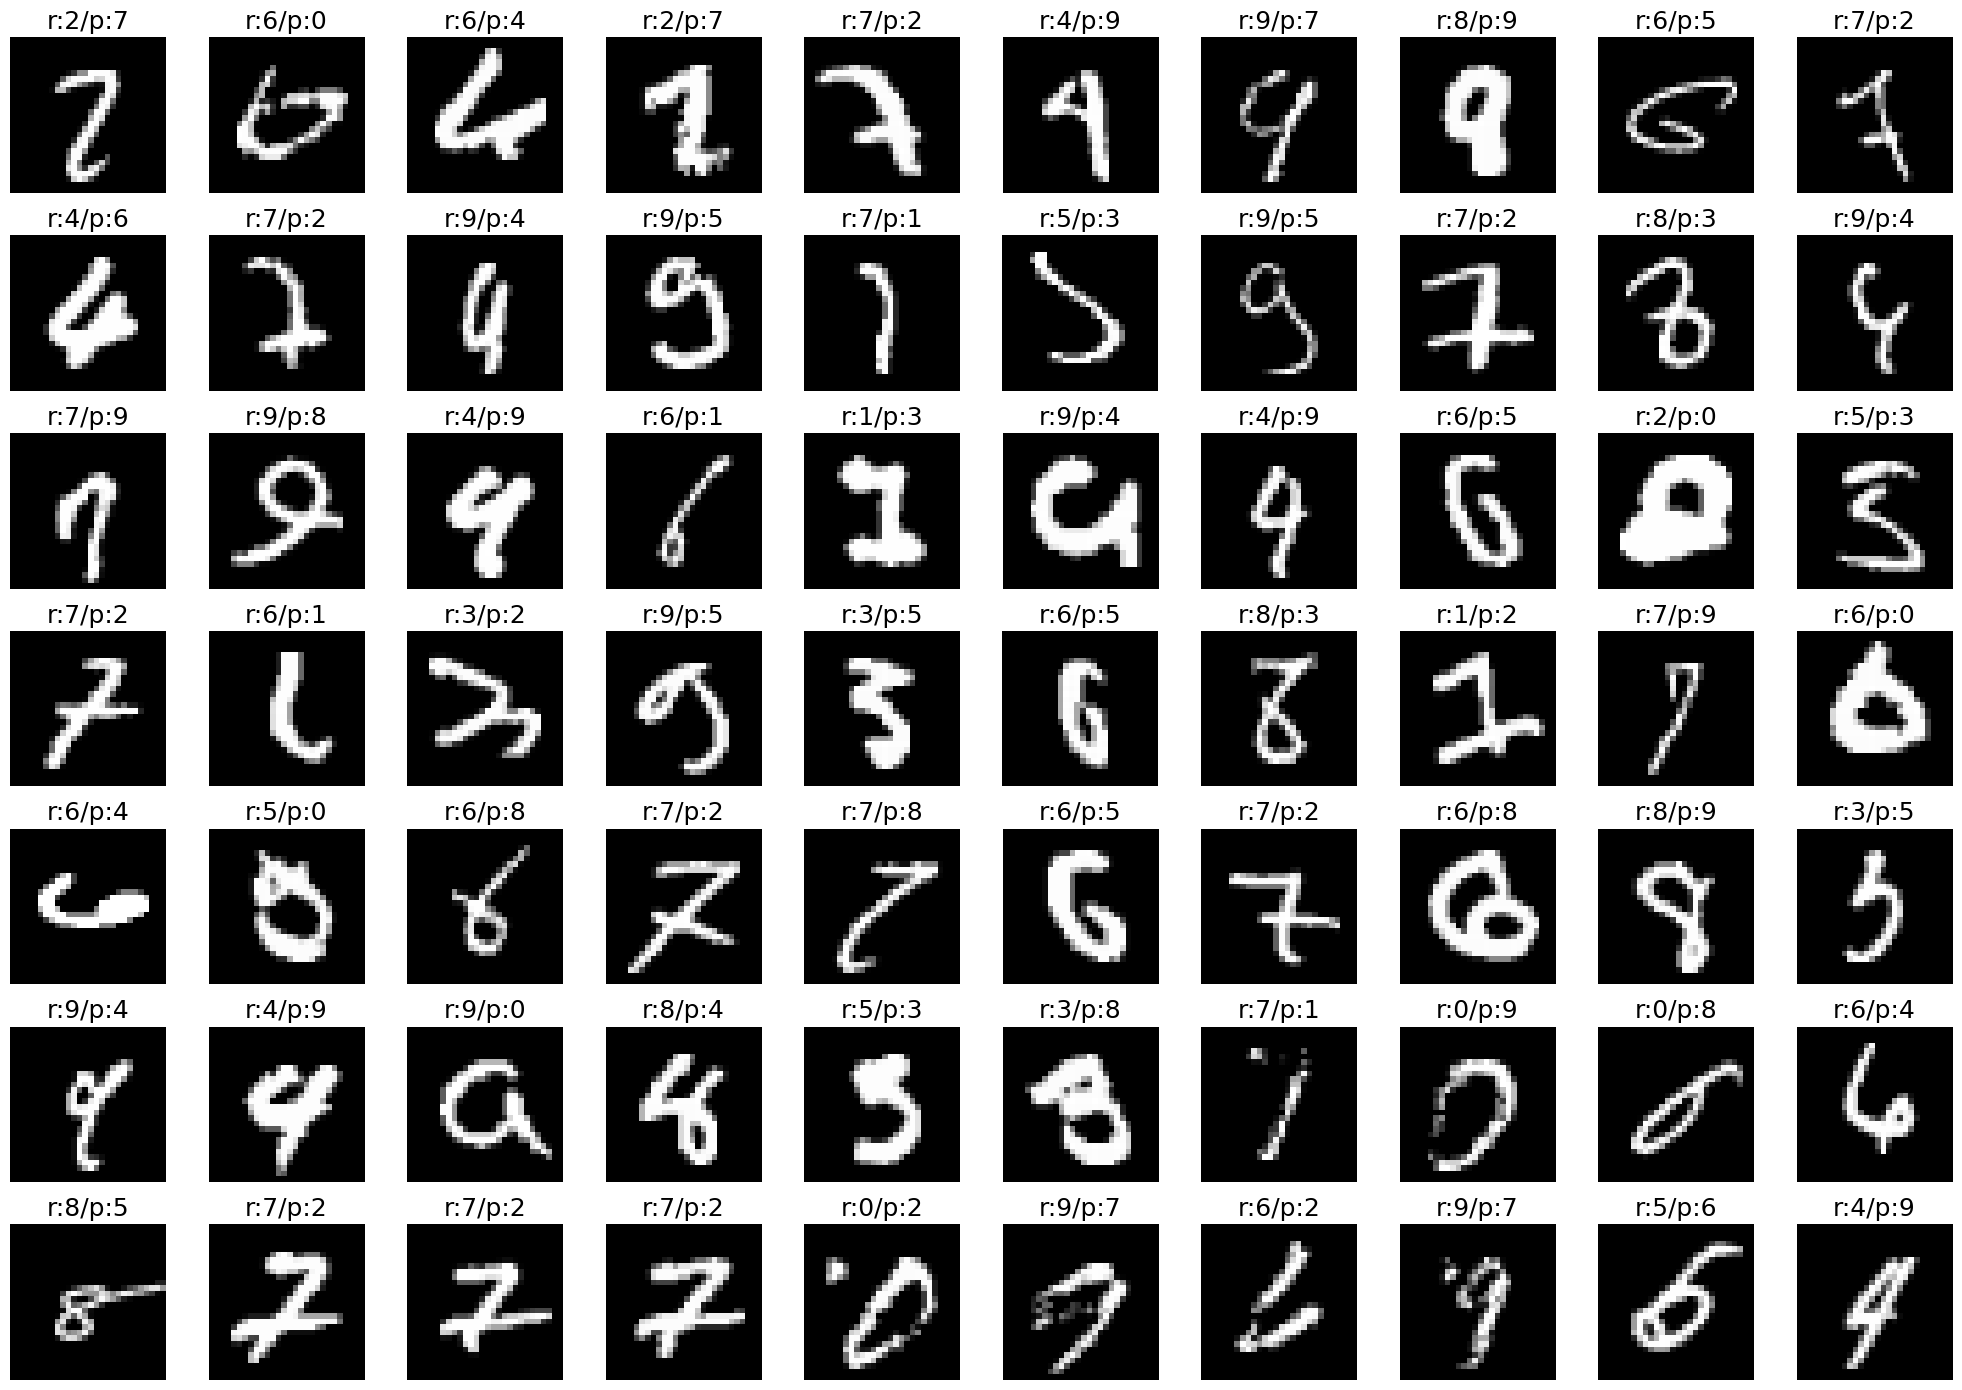

In [43]:
plt_row = 7
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col*2, plt_row*2)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력횟수 : 1~70
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    i += 1
    cnt += 1
plt.tight_layout()

In [41]:
cnt

70